<a href="https://colab.research.google.com/github/tnewtont/House_Prices_Regression/blob/main/house_prices_modeling_feat_engineering_outliers_winsor_top1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
import random
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import missingno as msno
import math
import pickle

from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
import scipy.stats as stats
from sklearn.preprocessing import TargetEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, TheilSenRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE, RFECV

# Important Functions

In [2]:
# A simple function to quickly load each .csv file
def reader(file_path):
  df = pd.read_csv(file_path)
  return df

In [3]:
# Obtain train and test preds inverted
def get_train_test_preds(model, pt, xtrain, xtest):
  train_preds = model.predict(xtrain)
  train_preds_df = pd.DataFrame(train_preds.reshape(-1,1), columns = ["SalePrice_win"])
  train_preds_inv = pt.inverse_transform(train_preds_df)

  test_preds = model.predict(xtest)
  test_preds_df = pd.DataFrame(test_preds.reshape(-1,1), columns = ["SalePrice_win"])
  test_preds_inv = pt.inverse_transform(test_preds_df)

  return train_preds, train_preds_inv, test_preds, test_preds_inv

In [4]:
# Calculate adjusted R-squared
def calc_adj_r2(p, y_true, y_pred):
  n = len(y_true)
  r2_test = r2_score(y_true, y_pred)
  adj_r2 = 1 - (1 - r2_test) * ((n-1)/(n-p-1))
  return adj_r2

In [5]:
def calculate_adj_r2(xtrain, ytrain, ytest, train_preds, test_preds):
  # Compute R^2 for the training set:
  r2_train = r2_score(ytrain, train_preds)
  print("R² (training):", r2_train)

  # Number of training samples and predictors:
  n_train = len(ytrain)           # or xtrain.shape[0]
  p = xtrain.shape[1]

  # Compute Adjusted R^2 for training set:
  adj_r2_train = 1 - ( (1 - r2_train) * (n_train - 1) / (n_train - p - 1) )
  print("Adjusted R² (training):", adj_r2_train)

  # Similarly for the test set (if you want to report it):
  r2_test = r2_score(ytest, test_preds)
  print("R² (test):", r2_test)
  n_test = len(ytest)
  adj_r2_test = 1 - ( (1 - r2_test) * (n_test - 1) / (n_test - p - 1) )
  print("Adjusted R² (test):", adj_r2_test)

In [6]:
# Make the submission dataframe. This assumes the model object has already been
# fitted with the training data
def make_submission(model, pt, x_test):
  sub_preds = model.predict(x_test)
  sub_preds_df = pd.DataFrame(sub_preds.reshape(-1,1), columns = ['SalePrice_win'])
  sub_preds_df['SalePrice_win'] = pt.inverse_transform(sub_preds_df)
  sub_preds_df_final = pd.concat([id_test, sub_preds_df], axis = 1)
  sub_preds_df_final.rename(columns={'SalePrice_win': 'SalePrice'}, inplace=True)
  return sub_preds_df_final

# Preparation

In [7]:
# Load the necessary dataframes
train = reader('/content/train_final.csv')
test = reader('/content/test_final.csv')

with open('boxcox_transformer.pickle', 'rb') as f:
    pt = pickle.load(f)

In [8]:
train

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,ordinal__Electrical,ordinal__Functional,ordinal__ExterCond,ordinal__BsmtCond,ordinal__BsmtExposure,ordinal__LotShape,ordinal__ExterQual,ordinal__HeatingQC,ordinal__KitchenQual,SalePrice_win
0,1,-0.190476,-0.254076,0.5,0.0,0.652174,0.243243,1.193303,0.452790,0.0,...,3.0,6.0,4.0,4.0,3.0,3.0,2.0,0.0,2.0,0.574562
1,2,0.523810,0.030015,0.0,3.0,0.065217,-0.486486,0.000000,0.834679,0.0,...,3.0,6.0,4.0,4.0,1.0,3.0,3.0,0.0,3.0,0.222096
2,3,-0.047619,0.437624,0.5,0.0,0.608696,0.216216,0.986301,0.143910,0.0,...,3.0,6.0,4.0,4.0,2.0,0.0,2.0,0.0,2.0,0.751059
3,4,-0.428571,0.017663,0.5,0.0,-1.260870,-0.648649,0.000000,-0.235170,0.0,...,3.0,6.0,4.0,1.0,3.0,0.0,3.0,2.0,2.0,-0.438205
4,5,0.714286,1.181201,1.0,0.0,0.586957,0.162162,2.130898,0.381186,0.0,...,3.0,6.0,4.0,4.0,0.0,0.0,2.0,0.0,2.0,1.035628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,-0.333333,-0.385746,0.0,0.0,0.565217,0.162162,0.000000,-0.538435,0.0,...,3.0,6.0,4.0,4.0,3.0,3.0,3.0,0.0,3.0,0.129377
1456,1457,0.761905,0.913167,0.0,1.0,0.108696,-0.162162,0.724505,0.570727,163.0,...,3.0,2.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0,0.592776
1457,1458,-0.142857,-0.107831,0.5,4.0,-0.695652,0.324324,0.000000,-0.152334,0.0,...,3.0,6.0,2.0,1.0,3.0,3.0,0.0,0.0,2.0,1.197894
1458,1459,-0.047619,0.058918,-0.5,1.0,-0.500000,0.054054,0.000000,-0.469638,1029.0,...,0.0,6.0,4.0,4.0,2.0,3.0,3.0,2.0,2.0,-0.399873


In [9]:
test

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,onehot__MSSubClass_PUD,ordinal__Electrical,ordinal__Functional,ordinal__ExterCond,ordinal__BsmtCond,ordinal__BsmtExposure,ordinal__LotShape,ordinal__ExterQual,ordinal__HeatingQC,ordinal__KitchenQual
0,1461,0.523810,0.529521,-0.5,1.0,-0.260870,-0.891892,0.000000,0.118638,144.0,...,0.0,3.0,6.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0
1,1462,0.571429,1.182930,0.0,1.0,-0.326087,-0.972973,0.657534,0.757459,0.0,...,0.0,3.0,6.0,4.0,4.0,3.0,0.0,3.0,4.0,2.0
2,1463,0.238095,1.074975,-0.5,0.0,0.521739,0.108108,0.000000,0.572131,0.0,...,0.0,3.0,6.0,4.0,4.0,3.0,0.0,3.0,2.0,3.0
3,1464,0.428571,0.123394,0.0,1.0,0.543478,0.108108,0.121766,0.306774,0.0,...,0.0,3.0,6.0,4.0,4.0,3.0,0.0,3.0,0.0,2.0
4,1465,-1.238095,-1.105114,1.0,0.0,0.413043,-0.054054,0.000000,-0.169182,0.0,...,1.0,3.0,6.0,4.0,4.0,3.0,0.0,2.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,-2.285714,-1.863266,-1.0,2.0,-0.065217,-0.648649,0.000000,-0.538435,0.0,...,1.0,3.0,6.0,4.0,4.0,3.0,3.0,3.0,2.0,3.0
1455,2916,-2.285714,-1.873641,-1.0,0.0,-0.065217,-0.648649,0.000000,-0.184626,0.0,...,1.0,3.0,6.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0
1456,2917,4.333333,2.599185,-0.5,2.0,-0.282609,0.054054,0.000000,1.180063,0.0,...,0.0,3.0,6.0,4.0,4.0,3.0,3.0,3.0,0.0,3.0
1457,2918,-0.333333,0.237772,-0.5,0.0,0.413043,-0.054054,0.000000,-0.065286,0.0,...,0.0,3.0,6.0,4.0,4.0,0.0,3.0,3.0,4.0,3.0


We will save the training and test IDs and the SalePrice target and then drop the IDs.

In [10]:
id_train, id_test = train['Id'], test['Id']
sale_price = train['SalePrice_win']

In [11]:
train.drop(columns = 'Id', inplace = True)
test.drop(columns = 'Id', inplace = True)

In [12]:
x = train.drop(columns = 'SalePrice_win')
y = train[['SalePrice_win']]
x_test = test

We will now do an 80/20 train-test split.

In [13]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 42)

Here, we save the inverse-transformed SalePrice values of ytrain and ytest, as this will allow us to calculate the root mean squared error between the predicted and actual prices in the original domain.

In [14]:
ytrain_inv = pt.inverse_transform(ytrain)
ytest_inv = pt.inverse_transform(ytest)

# Modeling

## Ordinary Least Squares

### Model, Predictions, and R-Squared, Adjusted R-Squared, and Root Mean Squared Error

In [15]:
ols = LinearRegression()
ols.fit(xtrain, ytrain.values.ravel())

LinearRegression()

In [16]:
ols_train_preds, ols_train_preds_inv, ols_test_preds, ols_test_preds_inv = get_train_test_preds(ols, pt, xtrain, xtest)

In [17]:
ols_train_RMSE = (mean_squared_error(ytrain_inv, ols_train_preds_inv))**0.5
ols_train_RMSE

17260.09767003054

In [18]:
ols_test_RMSE = (mean_squared_error(ytest_inv, ols_test_preds_inv))**0.5
ols_test_RMSE

21200.826979822585

In [19]:
calculate_adj_r2(xtrain, ytrain, ytest, ols_train_preds, ols_test_preds)

R² (training): 0.9417742764272045
Adjusted R² (training): 0.9286994549743417
R² (test): 0.9143248714984118
Adjusted R² (test): 0.6762147741043875


### Ordinary Least Squares Submission

In [20]:
ols_submission = make_submission(ols, pt, x_test)
ols_submission

,Id,SalePrice
0,1461,118607.678358
1,1462,162273.749465
2,1463,187398.954958
3,1464,204340.858713
4,1465,197998.585035
...,...,...
1454,2915,84654.915358
1455,2916,79137.441659
1456,2917,166473.847588
1457,2918,123481.090113


In [21]:
ols_submission.to_csv('ols_submission.csv', index = False)

## Ordinary Least Squares with RFECV

In [22]:
model = LinearRegression()

rfecv = RFECV(estimator=model, step=1, cv=KFold(5), scoring='neg_mean_squared_error', n_jobs=-1)
rfecv.fit(xtrain, ytrain)

print("Optimal number of features: %d" % rfecv.n_features_)
print("Selected features:", xtrain.columns[rfecv.support_])

# Now transform your datasets:
xtrain_rfecv = rfecv.transform(xtrain)
xtest_rfecv = rfecv.transform(xtest)

# Fit your model on the selected features:
model.fit(xtrain_rfecv, ytrain.values.ravel())
y_pred_rfecv = model.predict(xtest_rfecv)

rmse_rfecv = np.sqrt(mean_squared_error(ytest, y_pred_rfecv))
r2_rfecv = r2_score(ytest, y_pred_rfecv)
print("Test RMSE (RFECV):", rmse_rfecv)
print("Test R² (RFECV):", r2_rfecv)

Optimal number of features: 173
Selected features: Index(['LotFrontage', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       'CentralAir',
       ...
       'onehot__MSSubClass_1.5Story', 'onehot__MSSubClass_2.5Story',
       'onehot__MSSubClass_2Story', 'onehot__MSSubClass_Duplex',
       'onehot__MSSubClass_Other', 'ordinal__Functional', 'ordinal__ExterCond',
       'ordinal__BsmtCond', 'ordinal__BsmtExposure', 'ordinal__KitchenQual'],
      dtype='object', length=173)
Test RMSE (RFECV): 0.31282562186568025
Test R² (RFECV): 0.9145897906704233


In [23]:
selected_feats_rfcev = list(xtrain.columns[rfecv.support_])

In [24]:
with open('selected_feats_OLS_RFECV.pickle', "wb") as f:
  pickle.dump(selected_feats_rfcev, f)

In [25]:
x_test_selected = x_test[selected_feats_rfcev]

In [26]:
ols_rfecv_model = LinearRegression()
ols_rfecv_model.fit(xtrain_rfecv, ytrain.values.ravel())

LinearRegression()

In [27]:
train_preds_sel, train_preds_sel_inv, test_preds_sel, test_preds_sel_inv = get_train_test_preds(ols_rfecv_model, pt, xtrain_rfecv, xtest_rfecv)

In [28]:
OLS_rfecv_sub = make_submission(ols_rfecv_model, pt, x_test_selected)
OLS_rfecv_sub

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


,Id,SalePrice
0,1461,119035.499383
1,1462,164590.809737
2,1463,187835.205581
3,1464,204338.049836
4,1465,198545.964485
...,...,...
1454,2915,84401.473536
1455,2916,78477.976584
1456,2917,166328.181818
1457,2918,124269.576249


In [29]:
OLS_rfecv_sub.to_csv('OLS_rfecv_submission.csv', index = False)

## Lasso

### Grid Search with Lasso on Alpha Values, 5-fold

In [30]:
param_grid = {
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
}

lasso = Lasso()
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5,
                    scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(xtrain, ytrain)
print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

Best parameters: {'alpha': 0.001}
Best score: -0.09643617610322146


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.306e+01, tolerance: 1.124e-01
  model = cd_fast.enet_coordinate_descent(


In [31]:
best_alpha_lasso_fe = grid.best_params_['alpha']
best_alpha_lasso_fe

0.001

In [32]:
with open('best_alpha_lasso_fe.pickle', "wb") as f:
  pickle.dump(best_alpha_lasso_fe, f)

### Model, Predictions, and R-Squared, Adjusted R-Squared, and Root Mean Squared Error

In [33]:
l = Lasso(alpha = best_alpha_lasso_fe)
l.fit(xtrain, ytrain)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.306e+01, tolerance: 1.124e-01
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.001)

In [34]:
l_train_preds, l_train_preds_inv, l_test_preds, l_test_preds_inv = get_train_test_preds(l, pt, xtrain, xtest)

Obtain the features.

In [35]:
coefs_l = l.coef_
feat_names_l = xtrain.columns
selected_feat_indices_l =np.where(coefs_l != 0)[0]
selected_feats_l = feat_names_l[selected_feat_indices_l]
selected_feats_l.to_list()

['LotArea',
 'OverallQual',
 'OverallCond',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'TotalBsmtSF',
 'CentralAir',
 '1stFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageYrBlt',
 'WoodDeckSF',
 'EnclosedPorch',
 'ScreenPorch',
 'MoSold',
 'YrSold',
 'LotDepth',
 'Frontage_Area_Ratio',
 'LogLotArea',
 'LogLotFrontage',
 'HouseAge',
 'Remodeled',
 'LogMasVnrArea',
 'VeneerAreaRatio',
 'Has2ndFlr',
 'TotalFlrSF',
 'OverallQual_LowQual_Interact',
 'LogGrLivArea',
 'GrLivAreaBin',
 'HasGarage',
 'OpenPorchSF_log',
 'EnclosedPorch_log',
 '3SsnPorch_log',
 'MoSold_sin',
 'MoSold_cos',
 'GrLivArea_x_TotRmsAbvGrd',
 '2ndFlrSF_x_GrLivArea',
 'BsmtFinSF1_x_BsmtFullBath',
 'OverallQual_x_GarageCars',
 '1stFlrSF_x_GrLivArea',
 'GarageYrBlt_x_GarageArea',
 'OverallQual_x_GarageArea',
 'OverallQual_x_YearRemodAdd',
 'OverallQual_x_TotalBsmtSF',
 'BsmtFinSF1_x_TotalBsmtSF',
 '2ndFlrSF_x_Bedro

In [36]:
with open('selected_feats_lasso.pickle', "wb") as f:
  pickle.dump(selected_feats_l, f)

In [37]:
len(selected_feats_l)

111

In [38]:
l_train_RMSE = (mean_squared_error(ytrain_inv, l_train_preds_inv))**0.5
l_train_RMSE

18777.86216499102

In [39]:
l_test_RMSE = (mean_squared_error(ytest_inv, l_test_preds_inv))**0.5
l_test_RMSE

19297.480235865503

In [40]:
calculate_adj_r2(xtrain, ytrain, ytest, l_train_preds, l_test_preds)

R² (training): 0.9336890973267905
Adjusted R² (training): 0.9187987162438243
R² (test): 0.9187091162812211
Adjusted R² (test): 0.6927838030887706


### Lasso Submission 5 fold

In [41]:
lasso_submission = make_submission(l, pt, x_test)
lasso_submission

,Id,SalePrice
0,1461,116759.582252
1,1462,161236.640903
2,1463,181966.516193
3,1464,198978.068187
4,1465,192159.873415
...,...,...
1454,2915,91843.490100
1455,2916,86675.980112
1456,2917,167235.598702
1457,2918,120533.430063


In [42]:
lasso_submission.to_csv('lasso_submission.csv', index = False)

## Ridge

### Grid Search with Ridge on Alpha Values, 5 fold

In [43]:
param_grid = {
    'alpha': np.logspace(-4, 3, 50) # Generates 50 values from 1e-4 to 1e3 on an evenly-spaced logarithmic space
}

rid = Ridge()
grid = GridSearchCV(estimator=rid, param_grid=param_grid, cv=5,
                    scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(xtrain, ytrain.values.ravel())
print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

Best parameters: {'alpha': np.float64(10.0)}
Best score: -0.09402315159723454


In [44]:
best_alpha_ridge_fe = grid.best_params_['alpha']
best_alpha_ridge_fe

np.float64(10.0)

In [45]:
# Serialize the best alpha for future use
with open('best_alpha_ridge_fe.pickle', 'wb') as file:
    pickle.dump(best_alpha_ridge_fe, file)

### Model, Predictions, and R-Squared, Adjusted R-Squared, and Root Mean Squared Error

In [46]:
ri = Ridge(alpha = best_alpha_ridge_fe)
ri.fit(xtrain, ytrain)

Ridge(alpha=np.float64(10.0))

In [47]:
ri_train_preds, ri_train_preds_inv, ri_test_preds, ri_test_preds_inv = get_train_test_preds(ri, pt, xtrain, xtest)

In [48]:
coefs_ri = ri.coef_
feat_names_ri = xtrain.columns
selected_feat_indices_ri =np.where(coefs_ri != 0)[0]
selected_feats_ri = feat_names_ri[selected_feat_indices_ri]
selected_feats_ri.to_list()

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'CentralAir',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'HasPool',
 'MoSold',
 'YrSold',
 'LotDepth',
 'Frontage_Area_Ratio',
 'LogLotArea',
 'LogLotFrontage',
 'HouseAge',
 'Remodeled',
 'HasMasVnr',
 'LogMasVnrArea',
 'VeneerAreaRatio',
 'TotalBsmtFinSF',
 'FinishedBsmtRatio',
 'UnfinishedBsmtRatio',
 'Has2ndFlr',
 'TotalFlrSF',
 'Prop2ndFlr',
 'FlrRatio',
 'HasLowQualFin',
 'OverallQual_LowQual_Interact',
 'LogGrLivArea',
 'Qual_GrLivArea',
 'GrLivAreaBin',
 'TotalBsmtBath',
 'HasGarage',
 'LogWoodDeckSF',
 'HasWoodDeck',
 'OpenPorchSF_log',
 'EnclosedPorch

In [49]:
len(selected_feats_ri)

214

In [50]:
with open('selected_feats_ridge.pickle', "wb") as f:
  pickle.dump(selected_feats_ri, f)

In [51]:
ri_train_RMSE = (mean_squared_error(ytrain_inv, ri_train_preds_inv))**0.5
ri_train_RMSE

18593.118489339693

In [52]:
ri_test_RMSE = (mean_squared_error(ytest_inv, ri_test_preds_inv))**0.5
ri_test_RMSE

19412.29552588563

In [53]:
calculate_adj_r2(xtrain, ytrain, ytest, ri_train_preds, ri_test_preds)

R² (training): 0.9352980099808382
Adjusted R² (training): 0.920768916734143
R² (test): 0.9157534771887706
Adjusted R² (test): 0.6816137904147046


### Ridge Submission

In [54]:
ridge_submission = make_submission(ri, pt, x_test)
ridge_submission

,Id,SalePrice
0,1461,116750.621646
1,1462,162532.362022
2,1463,181283.652602
3,1464,198998.335612
4,1465,192155.616434
...,...,...
1454,2915,89193.740093
1455,2916,84020.134569
1456,2917,168312.410048
1457,2918,118535.511977


In [55]:
ridge_submission.to_csv('ridge_submission.csv', index = False)

## Elastic Net

### Grid Search with Elastic Net on Alpha and L1 Ratio Values, 5 fold

In [56]:
param_grid = {
    'alpha': np.logspace(-4, 3, 50),    # Regularization strength
    'l1_ratio': np.linspace(0.1, 0.5, num=10)              # Balance between L1 and L2
}

en_model = ElasticNet(random_state=42)
grid_search = GridSearchCV(en_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(xtrain, ytrain.values.ravel())

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.245e+01, tolerance: 1.124e-01
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=ElasticNet(random_state=42), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 1.38949549e-04, 1.93069773e-04, 2.68269580e-04,
       3.72759372e-04, 5.17947468e-04, 7.19685673e-04, 1.00000000e-03,
       1.38949549e-03, 1.93069773e-03, 2.68269580e-03, 3.72759372e-03,
       5.17947468e-03, 7.19685673e-03, 1.00000000e-02, 1.38949549e-02,
       1.93069773e-02, 2....
       1.38949549e+01, 1.93069773e+01, 2.68269580e+01, 3.72759372e+01,
       5.17947468e+01, 7.19685673e+01, 1.00000000e+02, 1.38949549e+02,
       1.93069773e+02, 2.68269580e+02, 3.72759372e+02, 5.17947468e+02,
       7.19685673e+02, 1.00000000e+03]),
                         'l1_ratio': array([0.1       , 0.14444444, 0.18888889, 0.23333333, 0.27777778,
       0.32222222, 0.36666667, 0.41111111, 0.45555556, 0.5       ])},
             scoring='neg_mean_squared_error')

In [57]:
best_alpha_en_fe = grid_search.best_params_['alpha']
best_l1_ratio_en_fe = grid_search.best_params_['l1_ratio']

In [58]:
with open('best_alpha_en.pickle', "wb") as f:
  pickle.dump(best_alpha_en_fe, f)

with open('best_l1_ratio_en.pickle', "wb") as f:
  pickle.dump(best_l1_ratio_en_fe, f)

### Model, Predictions, and R-Squared, Adjusted R-Squared, and Root Mean Squared Error

In [59]:
en = ElasticNet(alpha = best_alpha_en_fe, l1_ratio = best_l1_ratio_en_fe)
en.fit(xtrain, ytrain.values.ravel())

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.245e+01, tolerance: 1.124e-01
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=np.float64(0.007196856730011514), l1_ratio=np.float64(0.1))

In [60]:
en_train_preds, en_train_preds_inv, en_test_preds, en_test_preds_inv = get_train_test_preds(en, pt, xtrain, xtest)

In [61]:
coefs_en = en.coef_
feat_names_en = xtrain.columns
selected_feat_indices_en =np.where(coefs_en != 0)[0]
selected_feats_en = feat_names_en[selected_feat_indices_en]
selected_feats_en.to_list()

['LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'TotalBsmtSF',
 'CentralAir',
 '1stFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MoSold',
 'YrSold',
 'LotDepth',
 'Frontage_Area_Ratio',
 'LogLotArea',
 'LogLotFrontage',
 'HouseAge',
 'Remodeled',
 'HasMasVnr',
 'LogMasVnrArea',
 'VeneerAreaRatio',
 'TotalBsmtFinSF',
 'Has2ndFlr',
 'TotalFlrSF',
 'OverallQual_LowQual_Interact',
 'LogGrLivArea',
 'Qual_GrLivArea',
 'HasGarage',
 'OpenPorchSF_log',
 'EnclosedPorch_log',
 '3SsnPorch_log',
 'Has_OpenPorchSF',
 'MoSold_sin',
 'MoSold_cos',
 'GarageCars_x_GarageArea',
 'GrLivArea_x_TotRmsAbvGrd',
 'TotalBsmtSF_x_1stFlrSF',
 '2ndFlrSF_x_GrLivArea',
 'BedroomAbvGr_x_TotRmsAbvGrd',
 'BsmtFinSF1_x_BsmtFullBath',
 '

In [62]:
len(selected_feats_en)

148

In [63]:
with open('selected_feats_en.pickle', "wb") as f:
  pickle.dump(selected_feats_en, f)

In [64]:
en_train_RMSE = (mean_squared_error(ytrain_inv, en_train_preds_inv))**0.5
en_train_RMSE

19159.335431876323

In [65]:
en_test_RMSE = (mean_squared_error(ytest_inv, en_test_preds_inv))**0.5
en_test_RMSE

19426.978901340597

In [66]:
calculate_adj_r2(xtrain, ytrain, ytest, en_train_preds, en_test_preds)

R² (training): 0.9323011412333347
Adjusted R² (training): 0.9170990890024151
R² (test): 0.9151659590210831
Adjusted R² (test): 0.6793934295472102


### Elastic Net Submission

In [67]:
en_submission = make_submission(en, pt, x_test)
en_submission

,Id,SalePrice
0,1461,117788.595932
1,1462,160918.096601
2,1463,181336.117835
3,1464,199381.214355
4,1465,190009.679727
...,...,...
1454,2915,91775.021661
1455,2916,87041.993018
1456,2917,168315.103957
1457,2918,119862.286190


In [68]:
en_submission.to_csv('elasticnet_submission.csv', index = False)

## XGBRegressor

### Grid Search on n_estimators, learning_rate, max_depth, subsample and gamma values, 5-fold

In [69]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(xtrain, ytrain.values.ravel())

print("Best parameters:", grid_search.best_params_)
print("Best CV score (negative MSE):", grid_search.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.6}
Best CV score (negative MSE): -0.09520828650380411


In [70]:
# Extract the best model with the best parameters
best_xgb = grid_search.best_estimator_

In [71]:
xgb_train_preds, xgb_train_preds_inv, xgb_test_preds, xgb_test_preds_inv = get_train_test_preds(best_xgb, pt, xtrain, xtest)

In [72]:
xgb_train_RMSE = (mean_squared_error(ytrain_inv, xgb_train_preds_inv))**0.5
xgb_train_RMSE

5335.859405544459

In [73]:
xgb_test_RMSE = (mean_squared_error(ytest_inv, xgb_test_preds_inv))**0.5
xgb_test_RMSE

21382.802741575975

In [74]:
calculate_adj_r2(xtrain, ytrain, ytest, xgb_train_preds, xgb_test_preds)

R² (training): 0.9945204257965088
Adjusted R² (training): 0.993289965272325
R² (test): 0.9076567888259888
Adjusted R² (test): 0.6510146175112044


### XGBRegressor Submission

In [75]:
xgb_submission = make_submission(best_xgb, pt, x_test)
xgb_submission

,Id,SalePrice
0,1461,127932.625000
1,1462,163486.453125
2,1463,181545.187500
3,1464,193669.921875
4,1465,183015.875000
...,...,...
1454,2915,83265.921875
1455,2916,85521.117188
1456,2917,158119.062500
1457,2918,115254.828125


In [76]:
xgb_submission.to_csv('xgb_submission.csv', index = False)

## Random Forest Regressor

In [77]:
param_grid = {
    # How many trees in the forest
    'n_estimators': [100, 300, 500],
    # Maximum depth of each tree (None = grow until leaves are pure or min_samples_leaf)
    'max_depth': [None, 10, 20, 30],
    # Minimum number of samples required to split an internal node
    'min_samples_split': [2, 5, 10],
    # Minimum number of samples required to be at a leaf node
    'min_samples_leaf': [1, 2, 4],
    # Number of features to consider at each split
    'max_features': ['auto', 'sqrt', 'log2'],
}


rf = RandomForestRegressor(random_state=42)


grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(xtrain, ytrain.values.ravel())

print("Best params:", grid_search.best_params_)
print("Best CV score:", np.sqrt(-grid_search.best_score_))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
337 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py"

Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best CV score: 0.3505863396854853


In [78]:
best_rf = grid_search.best_estimator_

In [79]:
rf_train_preds, rf_train_preds_inv, rf_test_preds, rf_test_preds_inv = get_train_test_preds(best_rf, pt, xtrain, xtest)

In [80]:
rf_train_RMSE = (mean_squared_error(ytrain_inv, rf_train_preds_inv))**0.5
rf_train_RMSE

9519.239293743372

In [81]:
rf_test_RMSE = (mean_squared_error(ytest_inv, rf_test_preds_inv))**0.5
rf_test_RMSE

23618.6551574059

In [82]:
calculate_adj_r2(xtrain, ytrain, ytest, rf_train_preds, rf_test_preds)

R² (training): 0.9830719629514995
Adjusted R² (training): 0.9792707038451205
R² (test): 0.8781016673992528
Adjusted R² (test): 0.5393192884828903


In [83]:
rf_submission = make_submission(best_rf, pt, x_test)
rf_submission

,Id,SalePrice
0,1461,124868.776099
1,1462,154302.688229
2,1463,172799.355723
3,1464,185048.412993
4,1465,200327.002479
...,...,...
1454,2915,88744.102293
1455,2916,90638.595756
1456,2917,154441.777480
1457,2918,113679.775469


In [84]:
rf_submission.to_csv('random_forest_submission.csv', index = False)

## Theil-Sen

### Model, Predictions, and R-Squared, Adjusted R-Squared, and Root Mean Squared Error

In [85]:
ts = TheilSenRegressor(random_state=42)
ts.fit(xtrain, ytrain.values.ravel())

TheilSenRegressor(random_state=42)

In [86]:
ts_train_preds, ts_train_preds_inv, ts_test_preds, ts_test_preds_inv = get_train_test_preds(ts, pt, xtrain, xtest)

In [87]:
ts_train_RMSE = (mean_squared_error(ytrain_inv, ts_train_preds_inv))**0.5
ts_train_RMSE

26261.157484639225

In [88]:
ts_test_RMSE = (mean_squared_error(ytest_inv, ts_test_preds_inv))**0.5
ts_test_RMSE

21208.019186759117

In [89]:
calculate_adj_r2(xtrain, ytrain, ytest, ts_train_preds, ts_test_preds)

R² (training): 0.9173117339612711
Adjusted R² (training): 0.8987437497720917
R² (test): 0.9049354029960914
Adjusted R² (test): 0.6407298996345794


### Theil-Sen Submission

In [90]:
theil_sen_submission = make_submission(ts, pt, x_test)
theil_sen_submission

,Id,SalePrice
0,1461,119478.788412
1,1462,163626.839204
2,1463,188906.388796
3,1464,206374.316764
4,1465,198800.611245
...,...,...
1454,2915,85477.020029
1455,2916,76775.138403
1456,2917,166887.551992
1457,2918,120521.470516


In [91]:
theil_sen_submission.to_csv('theilsen_submission.csv', index = False)

# Diagnostic Plots

In [92]:
# Since the OLS with RFECV model was fitted on 200 features, while the rest were
# fitted with 214 (except Elastic Net at 148), we will wrap RFECV with OLS into its own pipeline
ols_rfecv_pipe = Pipeline([
    ('selector', RFECV(
        estimator=LinearRegression(),
        step=1,
        cv=5,
        scoring='neg_mean_squared_error'
    )),
    ('ols', LinearRegression())
])

ols_rfecv_pipe.fit(xtrain, ytrain.values.ravel())

Pipeline(steps=[('selector',
                 RFECV(cv=5, estimator=LinearRegression(),
                       scoring='neg_mean_squared_error')),
                ('ols', LinearRegression())])

In [93]:
models = {
  'OLS': ols,
  'OLS with RFECV': ols_rfecv_pipe,
  'Lasso': l,
  'Ridge': ri,
  'ElasticNet': en,
  'XGBRegressor': best_xgb,
  'Random Forest': best_rf,
  'Theil–Sen': ts
}

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


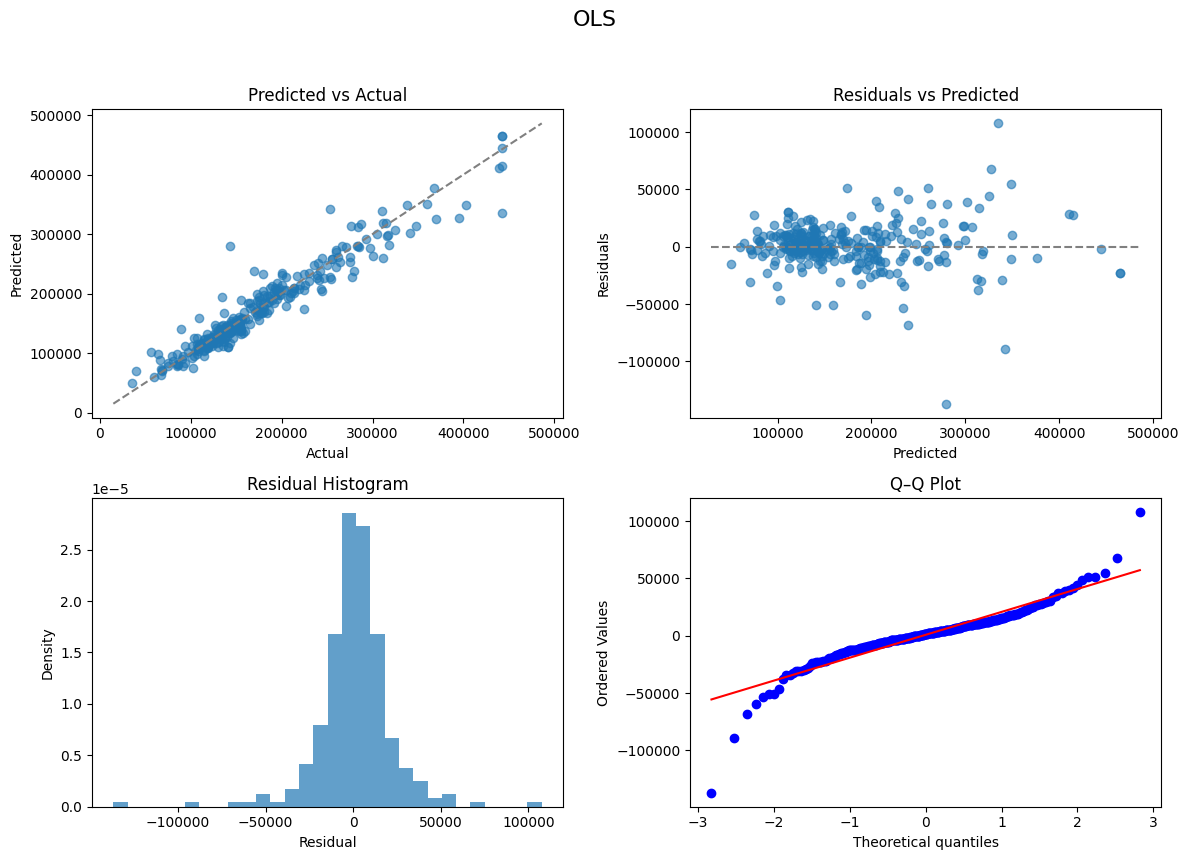

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


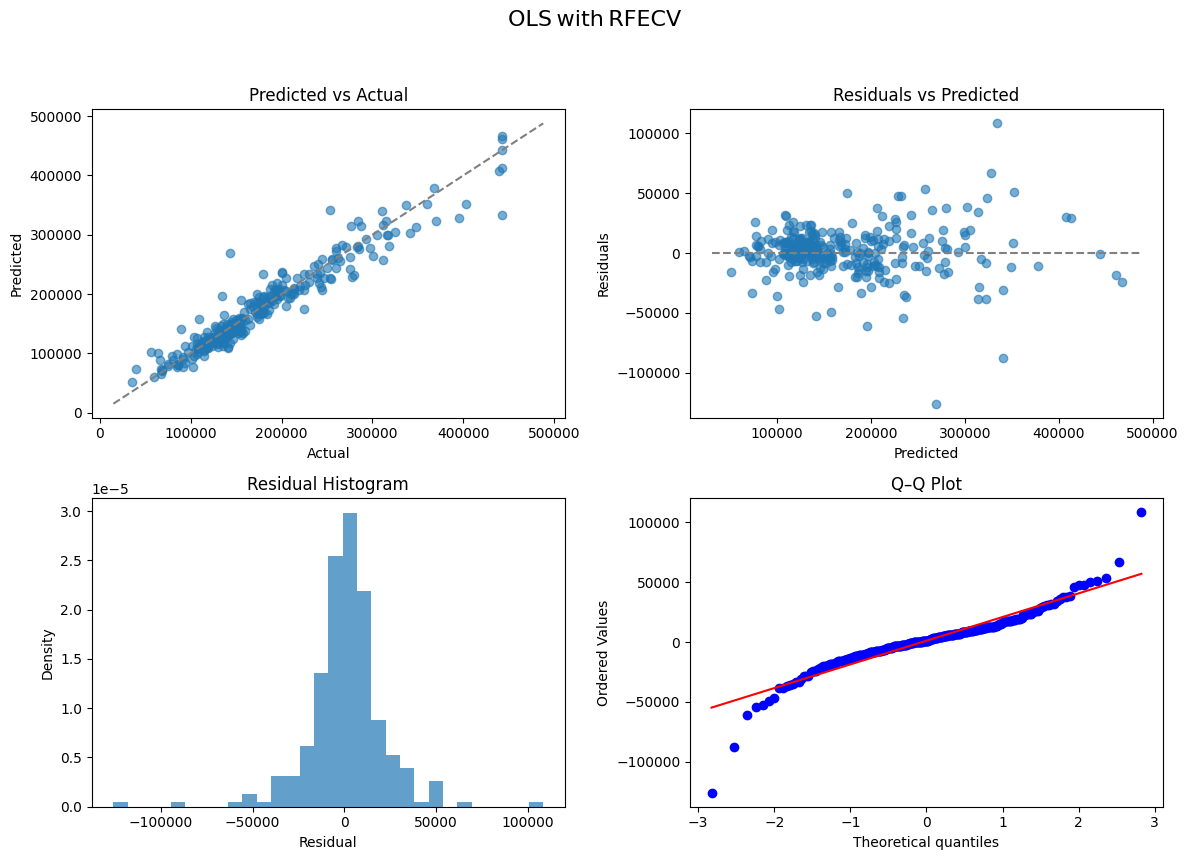

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


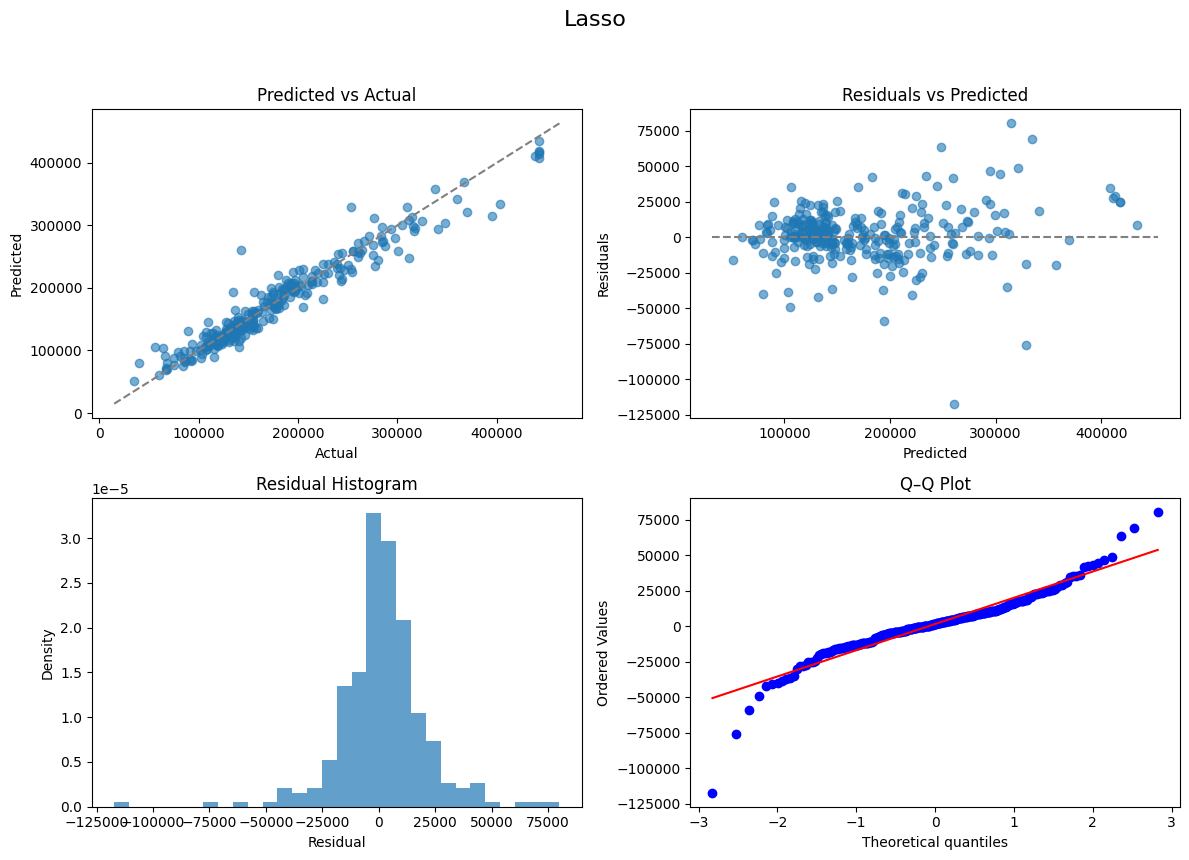

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


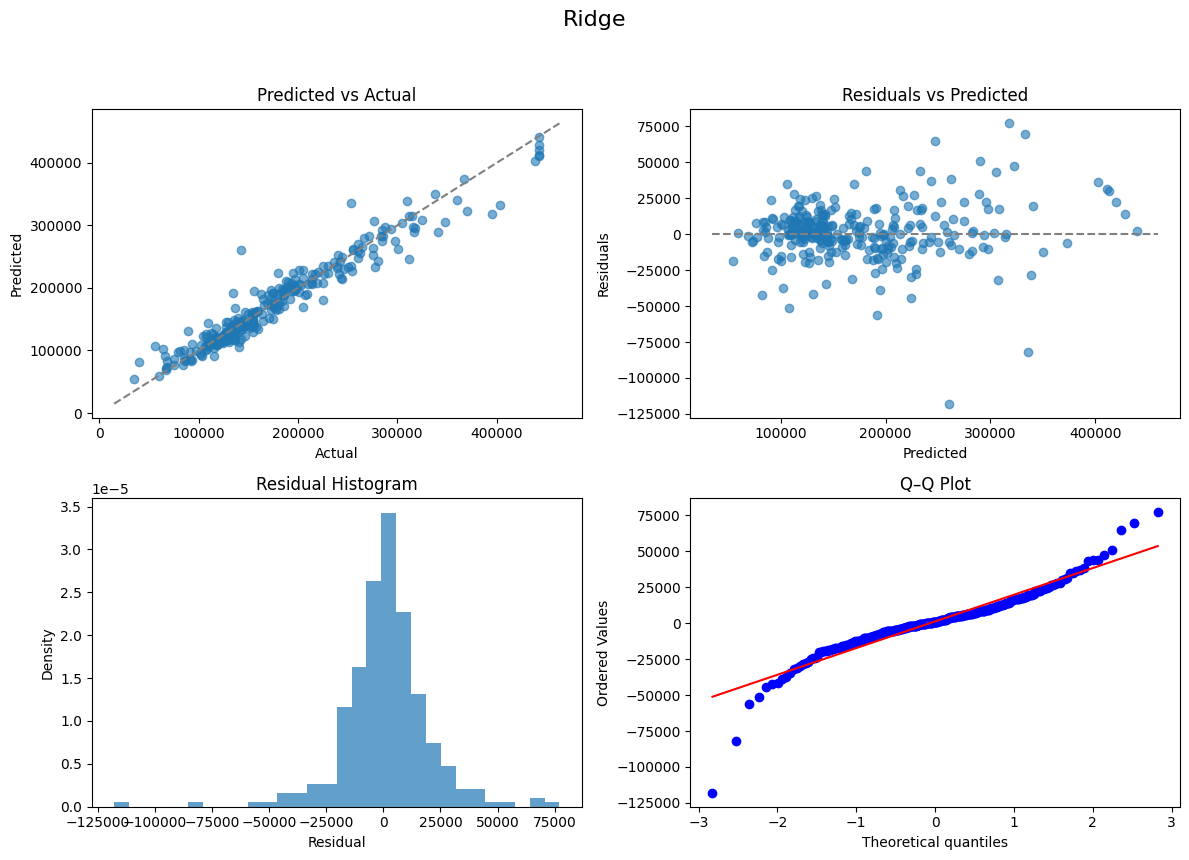

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


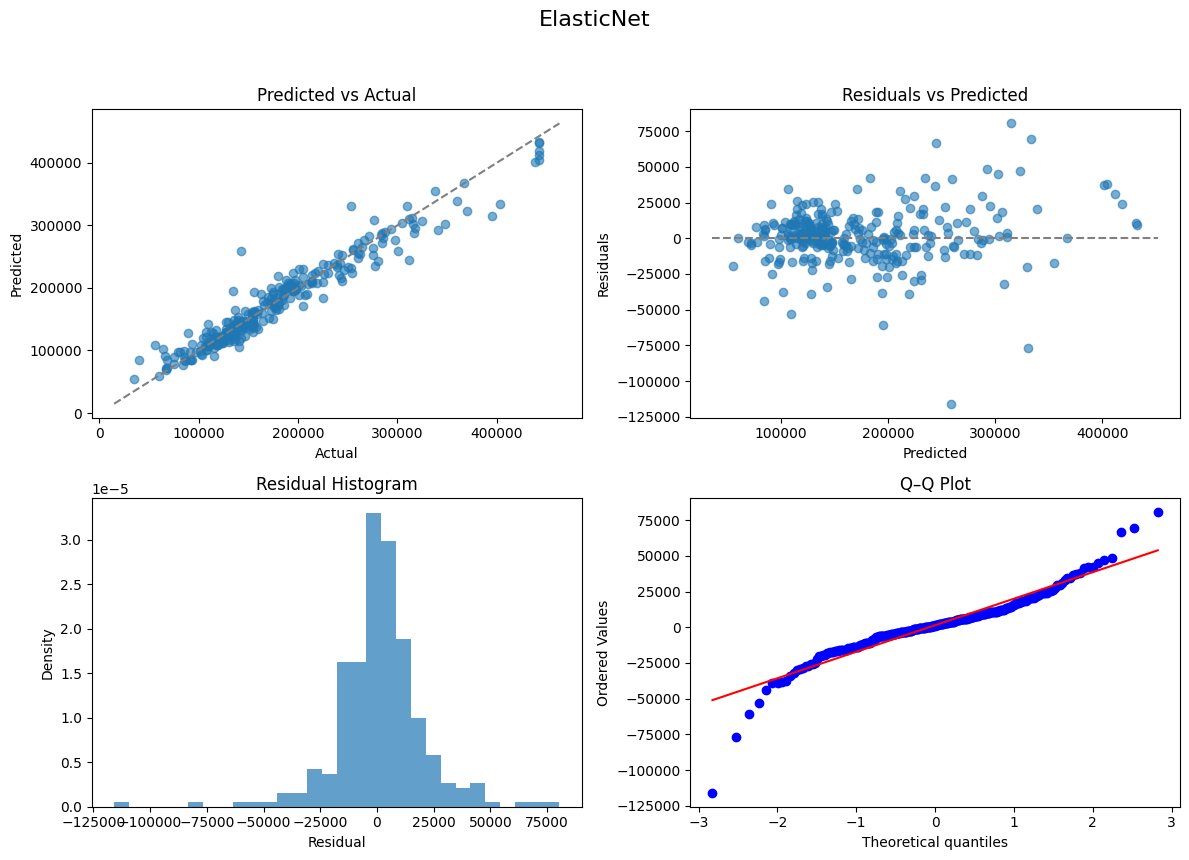

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


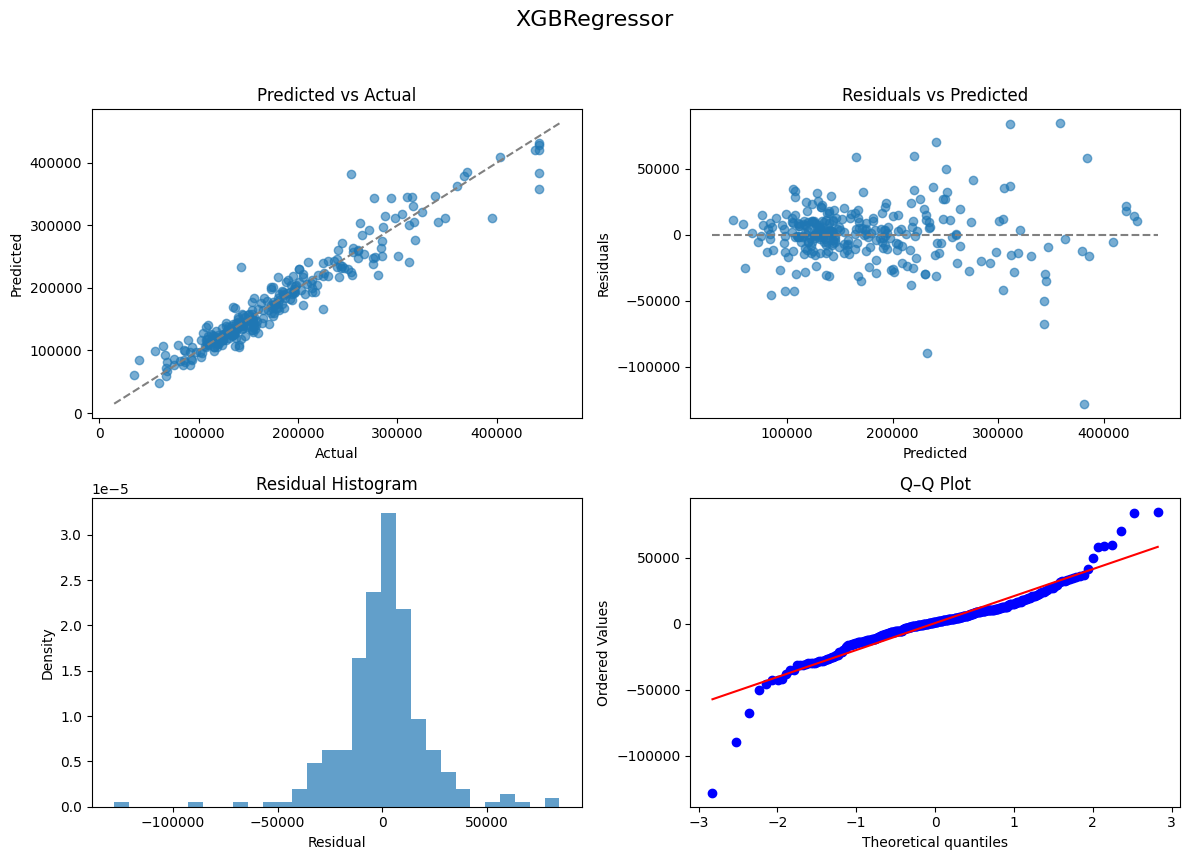

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


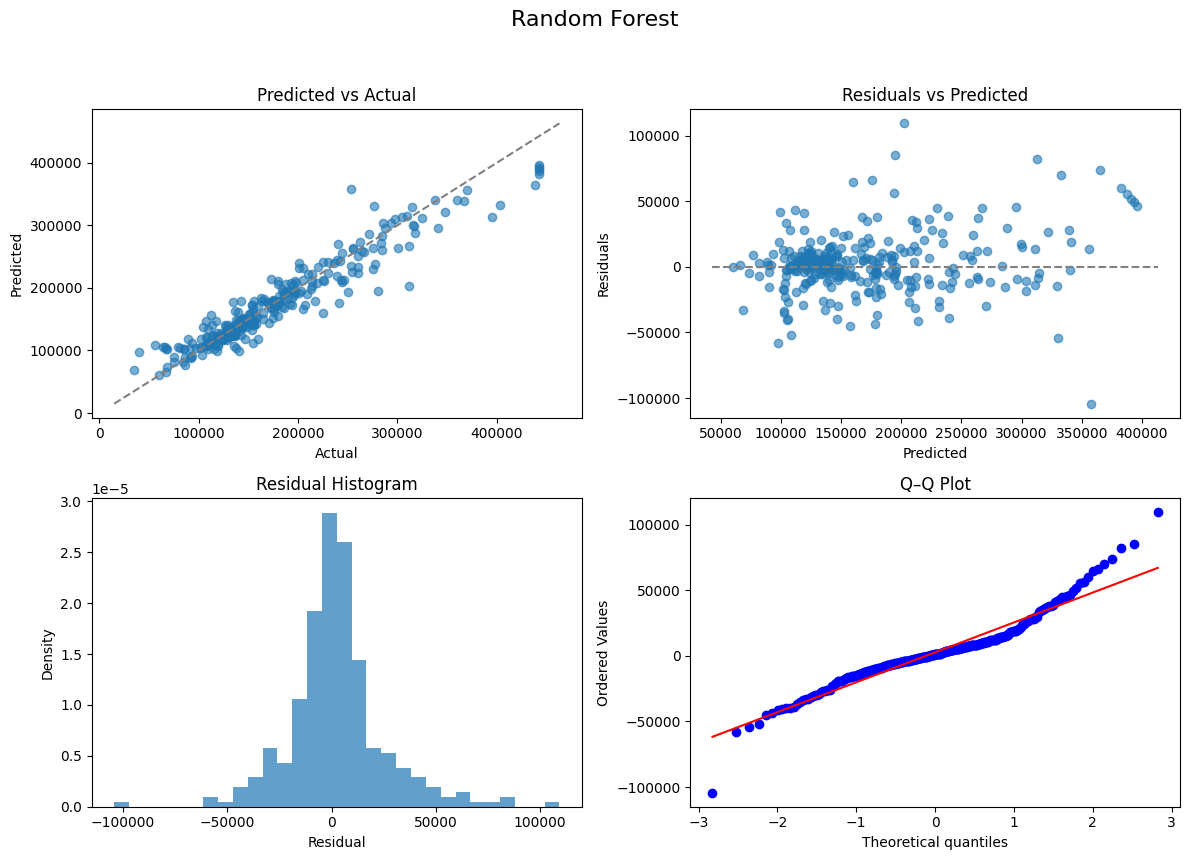

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


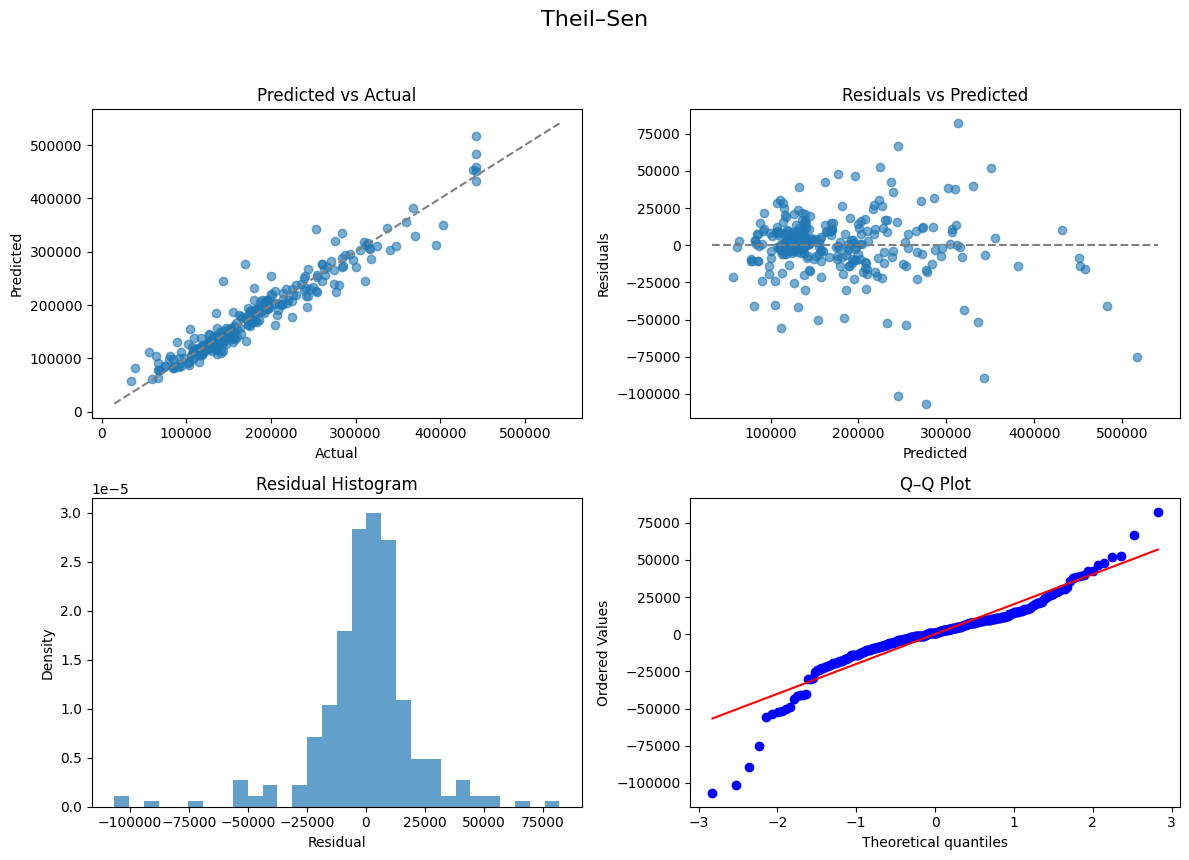

In [94]:
for name, model in models.items():

    y_pred_boxcox = model.predict(xtest)             # on Box-Cox scale
    y_pred = pt.inverse_transform(y_pred_boxcox.reshape(-1,1)).ravel()
    y_true = pt.inverse_transform(ytest).ravel()
    resid = y_true - y_pred

    fig, axes = plt.subplots(2,2, figsize=(12,9))
    fig.suptitle(name, fontsize=16)

    # Predicted vs Actual
    ax = axes[0,0]
    ax.scatter(y_true, y_pred, alpha=0.6)
    lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]),
            max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lims, lims, '--', color='gray')
    ax.set(title='Predicted vs Actual')
    ax.set(xlabel='Actual', ylabel='Predicted')

    # Residuals vs Predicted
    ax = axes[0,1]
    ax.scatter(y_pred, resid, alpha=0.6)
    ax.hlines(0, *ax.get_xlim(), linestyles='--', color='gray')
    ax.set(title='Residuals vs Predicted')
    ax.set(xlabel='Predicted', ylabel='Residuals')

    # Residual Histogram
    ax = axes[1,0]
    ax.hist(resid, bins=30, density=True, alpha=0.7)
    ax.set(title='Residual Histogram')
    ax.set(xlabel='Residual', ylabel='Density')

    # Q–Q Plot
    ax = axes[1,1]
    stats.probplot(resid, dist="norm", plot=ax)
    ax.set(title='Q–Q Plot')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Metrics and Results

In [95]:
# Another function that calculates adjusted R-squared
def adjusted_r2(r2, n, p):
    """
    r2     : R² score
    n      : number of samples
    p      : number of predictors (features)
    """
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Function that calculates symmetric mean absolute percentage error (SMAPE)
def smape(y_true, y_pred):
    # avoid divide‐by‐zero
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff  = np.abs(y_pred - y_true)
    mask  = denom > 0
    return np.mean(diff[mask] / denom[mask]) * 100

# For storing the results
results = []

for name, model in models.items():
    # Predict on the Box–Cox scale
    y_train_pred_bc = model.predict(xtrain)
    y_test_pred_bc  = model.predict(xtest)

    # Inverse–transform both true and pred back to dollars
    y_train_true_orig = ytrain_inv.ravel()
    y_train_pred_orig = pt.inverse_transform(y_train_pred_bc.reshape(-1,1)).ravel()
    y_test_true_orig  = ytest_inv.ravel()
    y_test_pred_orig  = pt.inverse_transform(y_test_pred_bc.reshape(-1,1)).ravel()

    # Compute metrics on the original scale
    rmse_train = np.sqrt(mean_squared_error(y_train_true_orig, y_train_pred_orig))
    rmse_test  = np.sqrt(mean_squared_error(y_test_true_orig,  y_test_pred_orig))
    rmsle_train = np.sqrt(mean_squared_log_error(y_train_true_orig, y_train_pred_orig))
    rmsle_test  = np.sqrt(mean_squared_log_error(y_test_true_orig,  y_test_pred_orig))
    mae_train = mean_absolute_error(y_train_true_orig, y_train_pred_orig)
    mae_test = mean_absolute_error(y_test_true_orig, y_test_pred_orig)
    smape_train = smape(y_train_true_orig, y_train_pred_orig)
    smape_test  = smape(y_test_true_orig,  y_test_pred_orig)


    r2_train = r2_score(y_train_true_orig, y_train_pred_orig)
    r2_test  = r2_score(y_test_true_orig,  y_test_pred_orig)

    # Number of features (as before)
    if hasattr(model, 'named_steps') and 'selector' in model.named_steps:
        p = model.named_steps['selector'].support_.sum()
    elif hasattr(model, 'coef_'):
        p = np.sum(model.coef_ != 0)
    else:
        p = xtrain.shape[1]

    adj_r2_train = adjusted_r2(r2_train, len(y_train_true_orig), p)
    adj_r2_test  = adjusted_r2(r2_test,  len(y_test_true_orig),  p)

    results.append({
        'n_features': p,
        'model': name,
        'rmse_train($)': rmse_train,
        'rmse_test($)': rmse_test,
        'rmsle_train($)': rmsle_train,
        'rmsle_test($)': rmsle_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'smape_train(%)': smape_train,
        'smape_test(%)': smape_test,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'adj_r2_train': adj_r2_train,
        'adj_r2_test': adj_r2_test,
    })

results_metrics = pd.DataFrame(results).set_index('model')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/

In [96]:
results_metrics

,n_features,rmse_train($),rmse_test($),rmsle_train($),rmsle_test($),mae_train,mae_test,smape_train(%),smape_test(%),r2_train,r2_test,adj_r2_train,adj_r2_test
model,,,,,,,,,,,,,
OLS,214,17260.097670,21200.826980,0.093021,0.123098,11675.981744,13842.418235,6.573991,8.162320,0.944531,0.925752,0.932075,0.719402
OLS with RFECV,173,17253.661299,20844.878324,0.093414,0.122896,11694.336993,13860.929174,6.601785,8.212344,0.944572,0.928225,0.934925,0.822995
Lasso,111,18777.862165,19297.480236,0.099270,0.119870,12173.831811,13022.480073,6.834922,7.846995,0.934347,0.938485,0.927445,0.900552
Ridge,214,18593.118489,19412.295526,0.098059,0.122021,12032.588980,12950.687849,6.738632,7.872308,0.935632,0.937751,0.921178,0.764748
ElasticNet,148,19159.335432,19426.978901,0.100306,0.122443,12284.675113,12981.932436,6.878788,7.885443,0.931652,0.937657,0.921725,0.873134
XGBRegressor,214,5335.859406,21382.802742,0.028545,0.127756,3862.321984,14280.964199,2.178442,8.507660,0.994699,0.924472,0.993508,0.714564
Random Forest,214,9519.239294,23618.655157,0.050147,0.146770,6096.598688,15970.619125,3.412393,9.473615,0.983128,0.907852,0.979339,0.651752
Theil–Sen,214,26261.157485,21208.019187,0.110922,0.129634,12507.467349,13820.665961,6.810716,8.299240,0.871592,0.925702,0.842757,0.719212


In [97]:
results_metrics.to_csv('results_metrics.csv', index = False)

# Top 10 Features for Each Model

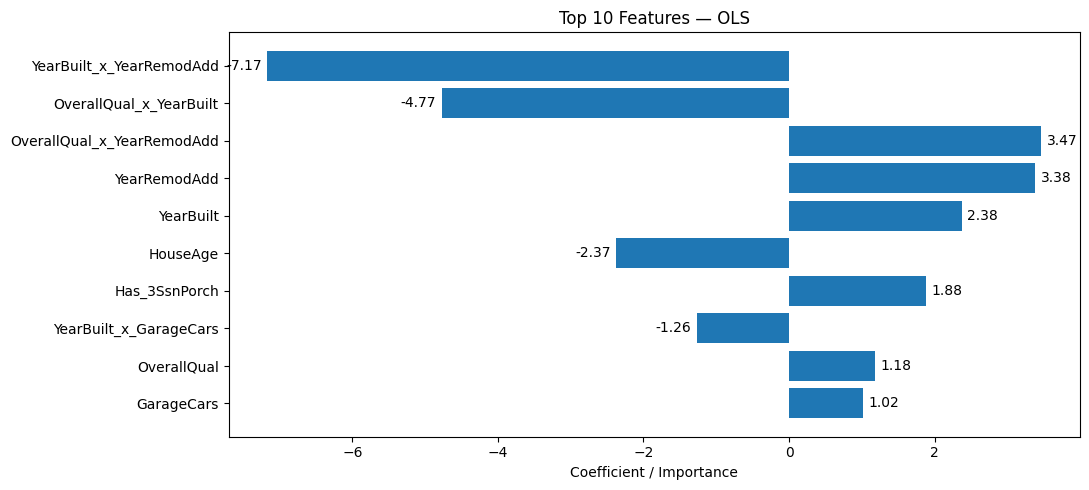

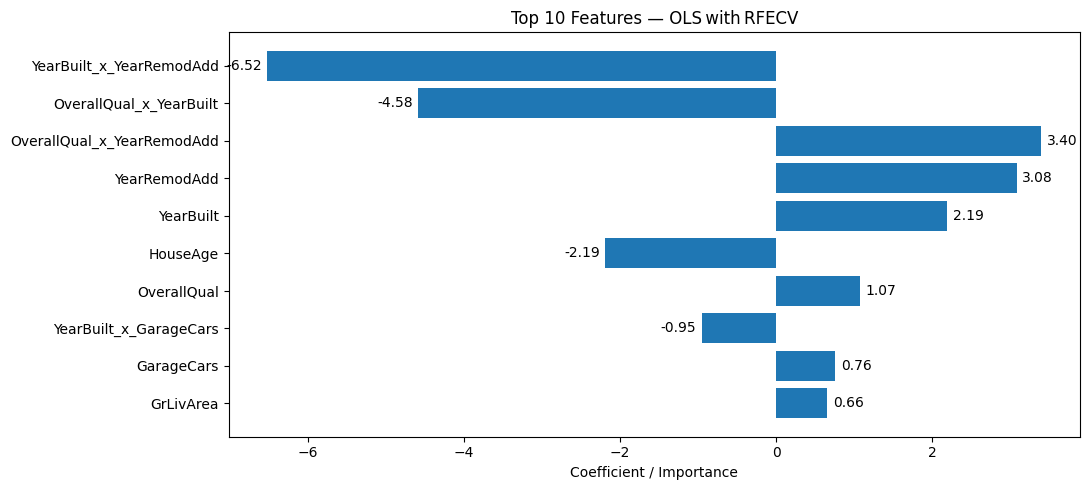

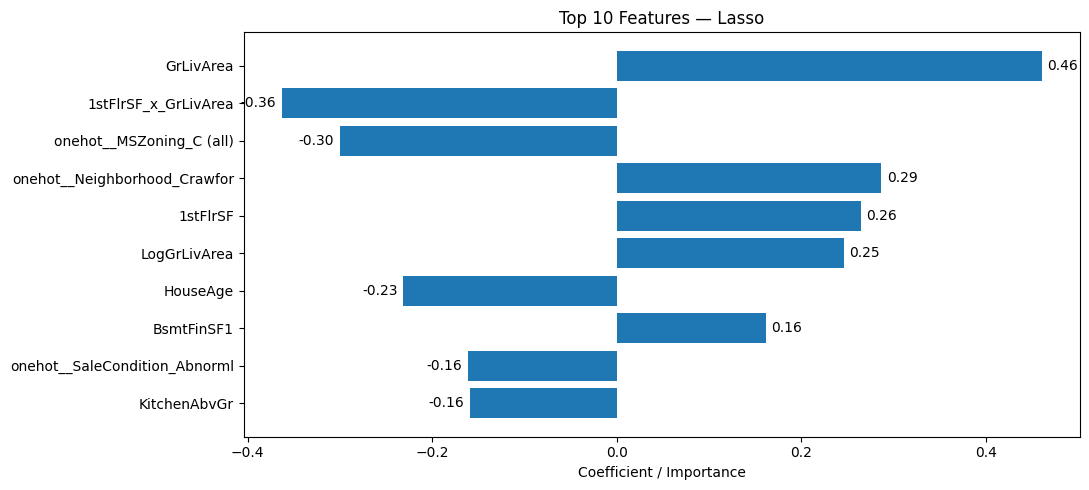

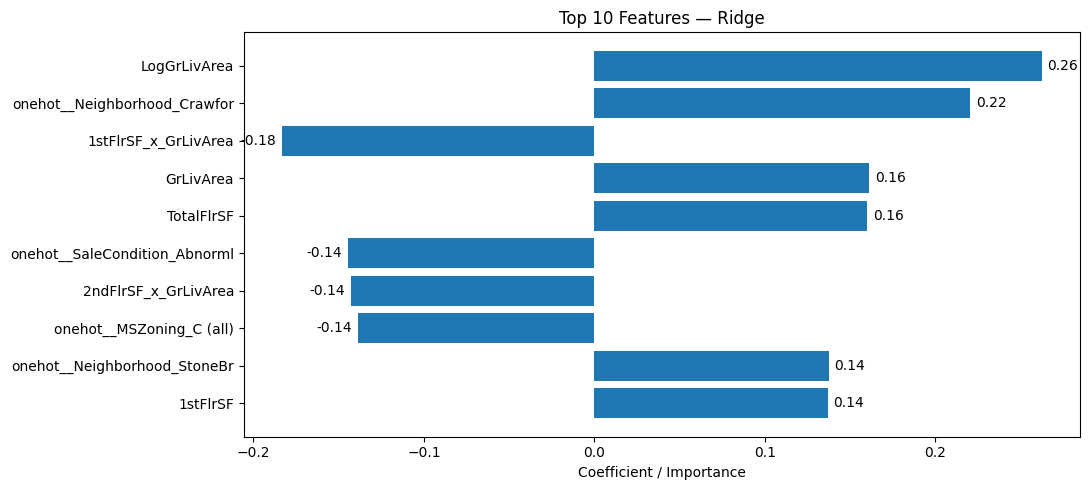

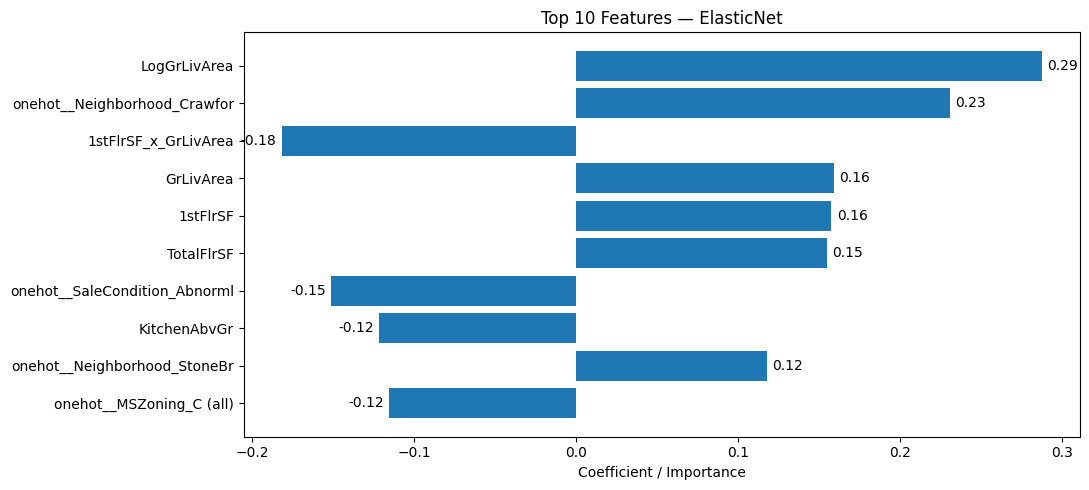

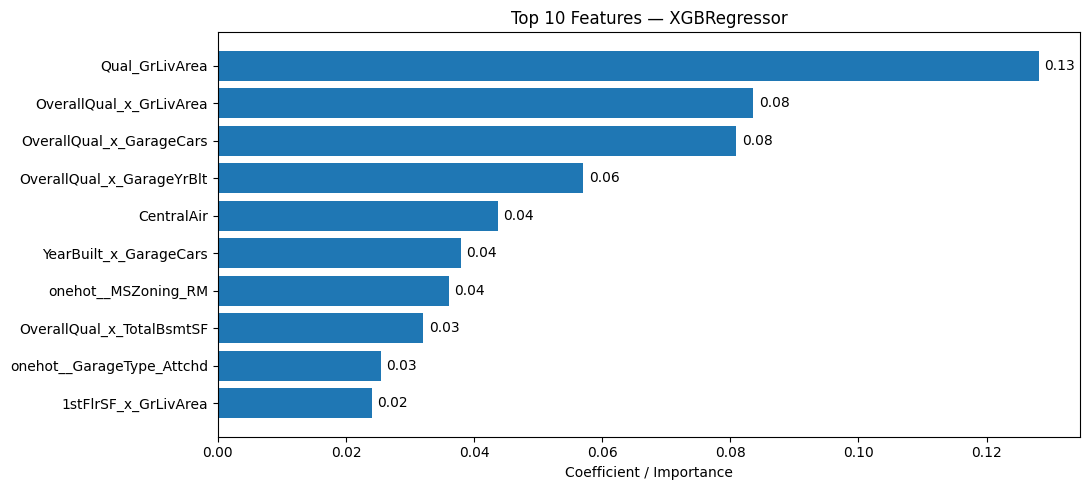

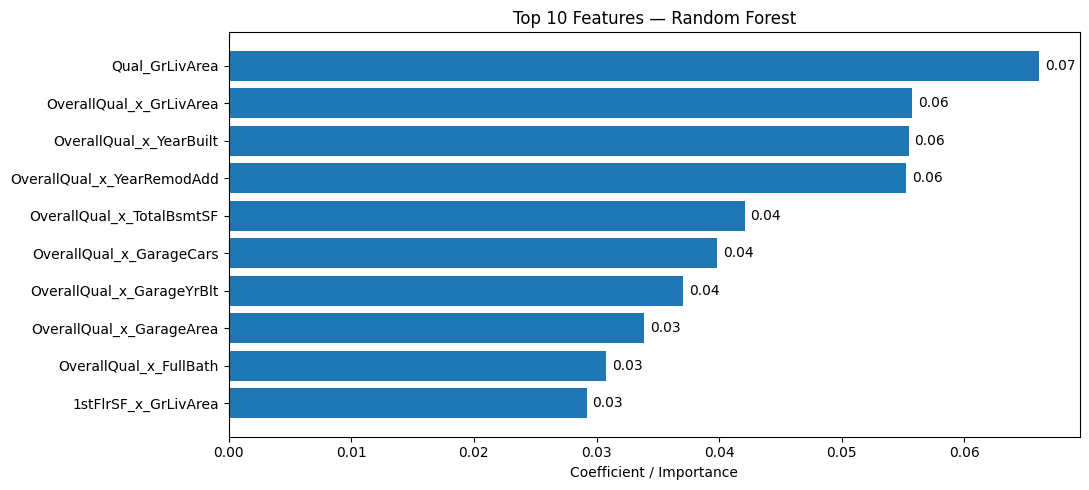

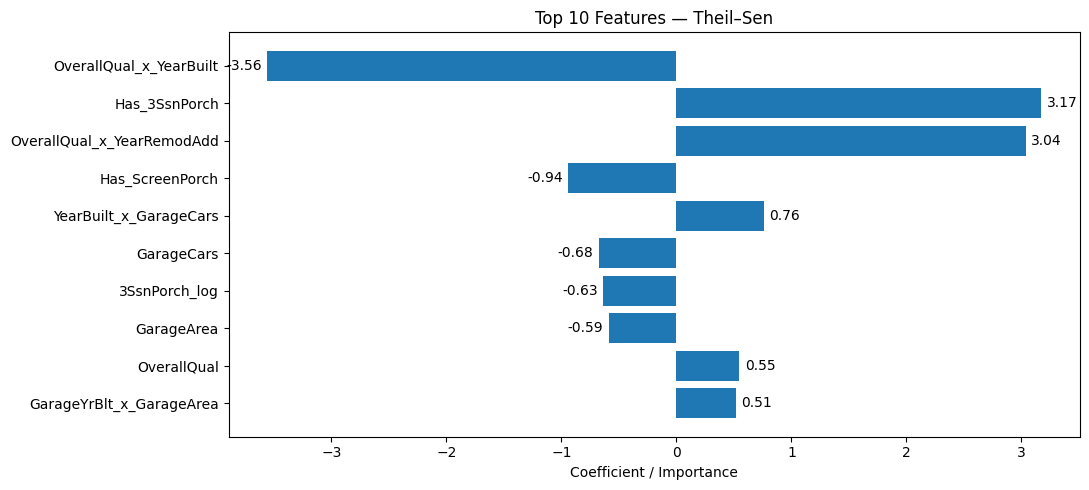

In [98]:
top_features = {}

for name, model in models.items():

    # Handle the OLS+RFECV pipeline specially
    if isinstance(model, Pipeline) and 'selector' in model.named_steps:
        # which cols were kept?
        support_mask = model.named_steps['selector'].support_
        # the final estimator’s coefs
        coefs = model.named_steps['ols'].coef_
        feat_names = xtrain.columns[support_mask]

    # Any other linear model w/ coef_
    elif hasattr(model, 'coef_'):
        coefs = model.coef_
        feat_names = xtrain.columns

    # Tree‐based models w/ feature_importances_
    elif hasattr(model, 'feature_importances_'):
        coefs = model.feature_importances_
        feat_names = xtrain.columns

    else:
        # skip if we don’t know how to extract importances
        continue

    # Pick the top 10 by absolute magnitude
    idx = np.argsort(np.abs(coefs))[::-1][:10]
    top10 = list(zip(feat_names[idx], coefs[idx]))
    top_features[name] = top10


# Plot separate figures for each model
for name, feats in top_features.items():

    feat_names, feat_vals = zip(*feats)
    feat_names = feat_names[::-1]
    feat_vals  = feat_vals[::-1]

    fig, ax = plt.subplots(figsize=(11,5))
    y_pos = np.arange(len(feat_names))
    bars = ax.barh(y_pos, feat_vals)

    # annotate values at the end of each bar
    ax.bar_label(bars, fmt='%.2f', padding=4)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(feat_names)
    ax.set_xlabel('Coefficient / Importance')
    ax.set_title(f'Top 10 Features — {name}')
    plt.tight_layout()
    plt.show()

We will serialize each model that we have created.

In [99]:
for mod in models:
  with open(f'{mod}_model.pickle', 'wb') as f:
    pickle.dump(models[mod], f)